In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
import pandas as pd

class ProcessAmazon():
    """Read, filter, aggregate by ProductId, and generate X matrix"""

    def __init__(self, raw_data_filename, num_reviews_filter, review_score_filter):
        """Initialize attributes."""
        self.raw_data_filename = raw_data_filename
        self.num_reviews_filter = num_reviews_filter
        self.review_score_filter = review_score_filter
        self.raw_data = self.read_and_report()
        self.grouped_by_userid = self.group_by_userid()
        self.filtered = self.filter_()
        self.grouped_by_productid = self.group_by_productid()
        self.X = self.write_X()
    
    def read_and_report(self):
        """Read Amazon csv, report on file structure"""
        data = pd.read_csv(self.raw_data_filename)
        print(self.raw_data_filename, "has", data.shape[0], "rows and", data.shape[1], "columns. First five observations:")
        print(data.head(5))
        print(50 * '-')
        return data
    
    def group_by_userid(self):
        """Group by UserId and look at the distribution of number of reviews"""
        grouped_by_uid = self.raw_data.groupby('UserId').count()
        print('Distribution of number of reviews for each UserId:')
        print(grouped_by_uid['ProductId'].value_counts())
        print(50 * '-')
        return grouped_by_uid
    
    def filter_(self):
        """Filter out reviewers with fewer than x reviews"""
        filtered = self.grouped_by_userid[self.grouped_by_userid['Id'] > self.num_reviews_filter]
        # remove redundant columns
        filtered_final = filtered.drop(filtered.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis=1)
        # recreate UserId from index
        filtered_final['UserId'] = filtered_final.index
        # rename columns
        filtered_final.columns = ['num_reviews', 'UserId']
        # left merge filtered list with raw data
        filtered = pd.merge(filtered_final, self.raw_data, how='left', on='UserId')
        filtered = filtered[filtered['Score'] >= self.review_score_filter]
        print("Filtered data has", filtered.shape[0], "rows and", filtered.shape[1], "columns. First five observations:")
        print(filtered.head(5))
        print(50 * '-')
        return filtered
    
    def group_by_productid(self):
        """Group by ProductId and create a column that lists each UserId (separated by spaces) who reviewed that product"""
        grouped_by_pid = self.filtered.groupby('ProductId')['UserId'].apply(lambda x: ' '.join(x)).reset_index()
        print("Data grouped by ProductId has", grouped_by_pid.shape[0], "rows and", grouped_by_pid.shape[1], "columns. First five observations:")
        print(grouped_by_pid.head(5))
        print(50 * '-')
        return grouped_by_pid
    
    def write_X(self):
        """use bag of words to create boolean X to represent reviews by UserId (one UserId per column)"""
        from sklearn.feature_extraction.text import CountVectorizer
        count = CountVectorizer()
        uidArray = self.grouped_by_productid.UserId.as_matrix()
        userFeatures = count.fit_transform(uidArray)
        print("Shape of final X matrix:", userFeatures.shape)
        return userFeatures

In [51]:
import pandas as pd
class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid, labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds', 'cluster']
        merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text']]
        return merged_lite

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))
    
    def view_specific_cluster(self, n_samples, sample):
        """Print specified sample"""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
#         for sample in range(1, num_clusters): 
        print(50 * '-')
        print('cluster: ', sample)
        cluster = merged.loc[merged['cluster'] == sample]
        print('cluster size: ', cluster.shape)
        print(cluster.sample(n_samples))
           
    # see how many products in each cluster    
    def view_graph(self):
        """Show bar graph showing number of unique products in each cluster"""
        merged = self.merge_labels() # from above
        num_clusters = self.model_instance.cluster_centers_.shape[0] # from above
        sizes = []
        labels = []
        
        for i in range (1, num_clusters):
            cluster = merged.loc[merged['cluster'] == i]
            sizes.append(cluster.shape[0])
            labels.append(i)
        
        y_pos = np.arange(len(sizes))
        
        plt.figure(figsize=(35,10))
        plt.bar(y_pos, sizes, .8, align='center', color='lime', alpha=0.5)
        plt.xticks(y_pos, labels)
        plt.ylabel('Size')
        plt.xlabel('Cluster')

In [61]:
# process Amazon.csv, filtering out people who left 10 or fewer reviews and reviews with scores lower than 5
amazonData = ProcessAmazon('Amazon.csv', 10, 5)

Amazon.csv has 455000 rows and 13 columns. First five observations:
   Unnamed: 0      Id   ProductId          UserId       ProfileName  \
0      138806  138807  B000E63LME  A1CQGW1AOD0LF2  Alena K. "Alena"   
1      469680  469681  B004ZIH4KM  A37S7U1OX2MCWI        Becky Cole   
2      238202  238203  B003ZXE9QA  A2OM6G73E64EQ9              jeff   
3      485307  485308  B001RVFERK  A25W349EE97NBK          Tangent4   
4      375283  375284  B000OQZNTS  A3CPPW0HUC07YS       Amy Nicolai   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      2  1294185600   
1                     0                       0      5  1349740800   
2                     0                       0      5  1329264000   
3                     1                       1      4  1248307200   
4                     0                       0      5  1333238400   

                     Summary  \
0           Not as pictured.   
1                   

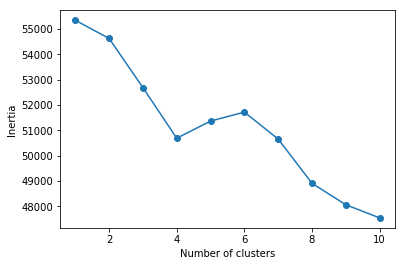

In [62]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(amazonData.X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [63]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=15, init='k-means++', max_iter=5000, random_state=11)
km.fit(amazonData.X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=5000,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=11, tol=0.0001, verbose=0)

In [64]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, km)

## Cluster Summaries

All of my 14 clusters are pretty good. No mega-clusters and none that are too broad or too specific. Quick summaries are below. I think the best clusters are **11**, which includes chocolate, coffee, and a few breakfast items, and **13**, which includes a few different kinds of snacks, meaning we could recommend something new to purchasers/. Other clusters are more related to one type of food, meaning we'd be giving users a recommendation of the same item they just bought.

The bar graph below shows the total number of products in each cluster and some highlighted plots are printed after. At the very end are the summaries of each cluster.

1. 492 Cookies, various kinds
2. *2485 Chips/Crisps, various flavours (one or two brands?)*
3. *3445 Tea, various flavours/types*
4. 1243 Baby Food
5. 328 Mostly Pretzels, some other snacks
6. 1021 Fine Cat Food
7. 1644 More tea, mostly licorice flavour
8. 1387 Cat Food, various types
9. 1697 Nuts, vrious kinds and flavours
10. 969 Loose Leaf Tea
11. **356 Chocolate, Cereal, and Coffee (Might be just one brand?)**
12. 1399 Chips/Crisps
13. **1012 Snacks, some chips, chocolates, crackers**
14. 724 Breakfast Cereals/Granola

###### Largest Clusters
* 3 - **3445 Tea, various flavours/types**
    Not a bad size, considering it is almost entirely different kinds of tea
* 2 - **2485 Chips/Crisps, various flavours (one or two brands?)**
    Also not bad. All chips and crisps, but various flavours and I think brands as well
* 9 - 1697 Nuts, vrious kinds and flavours

##### Cluster Sizes

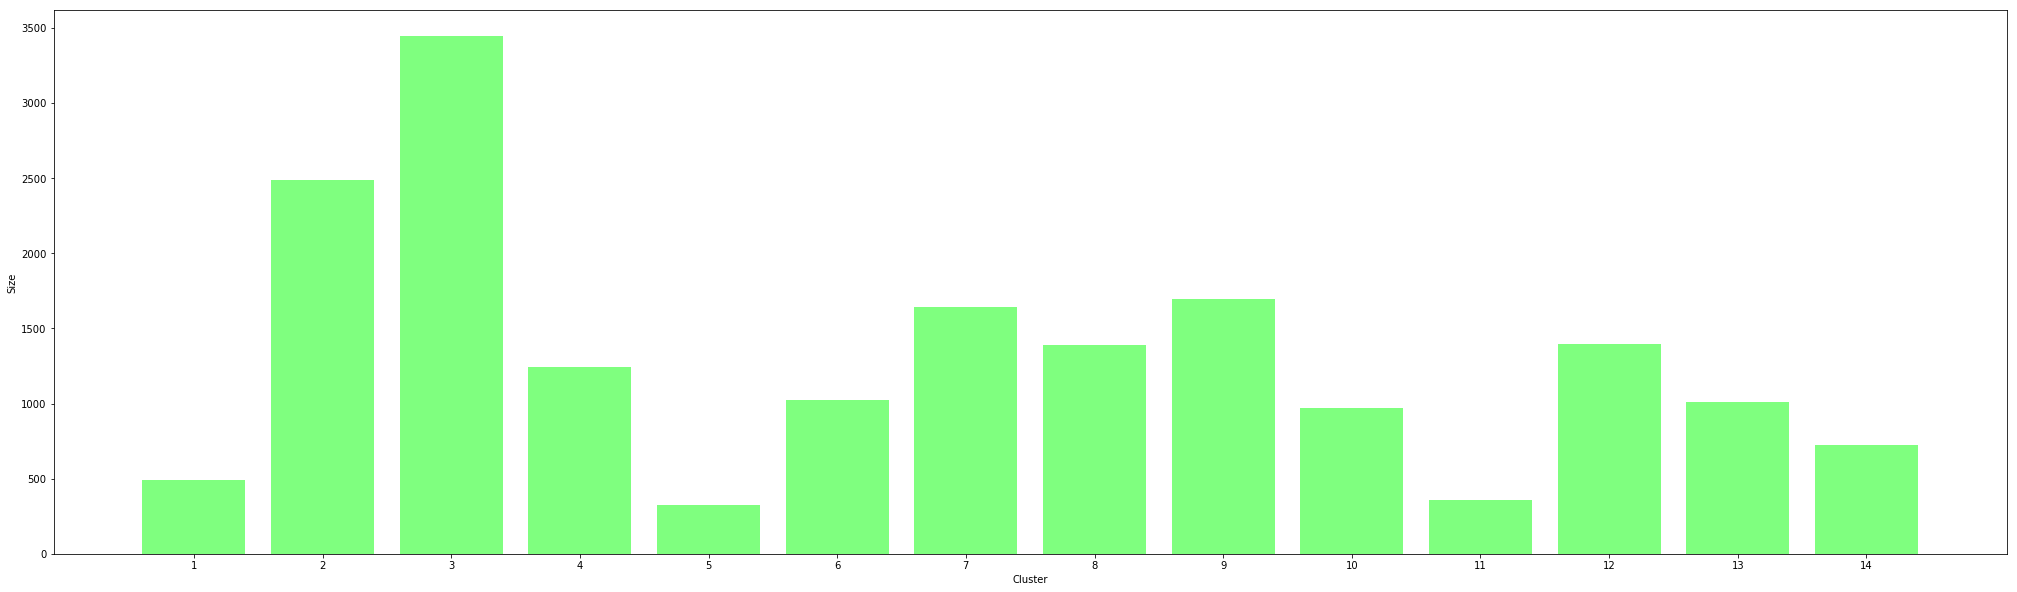

In [68]:
viz.view_graph()

In [71]:
viz.view_specific_cluster(10, 3)

--------------------------------------------------
cluster:  3
cluster size:  (3445, 4)
         ProductId  cluster  \
6515    B00020HHK4        3   
52350   B000FVDWU4        3   
110001  B0016B7Z32        3   
13225   B00073IVAQ        3   
52190   B000FVBYCW        3   
89898   B000VJYTZM        3   
107367  B0014B0HWK        3   
229832  B00412W76S        3   
147859  B001GCTTRQ        3   
147802  B001GCTTRQ        3   

                                                  Summary  \
6515                                            Yummy tea   
52350               very pleasant flavor and good quality   
110001                                          Great Tea   
13225                        Great quality Raspberry Leaf   
52190                                No more breast milk!   
89898                                        amazing!....   
107367                            Great tea for pregnancy   
229832                      Do not order this product....   
147859               

In [72]:
viz.view_specific_cluster(10, 2)

--------------------------------------------------
cluster:  2
cluster size:  (2485, 4)
         ProductId  cluster  \
234693  B00472I5A4        2   
256498  B0058AMY5G        2   
54326   B000G6RYNE        2   
234414  B004728MI4        2   
102758  B0012XBD7I        2   
234603  B00472I5A4        2   
72449   B000LKXBL4        2   
234607  B00472I5A4        2   
234465  B004728MI4        2   
102868  B0012XBD7I        2   

                                                  Summary  \
234693                                       kettle chips   
256498        70% of the chips in the bag are over cooked   
54326                          A tang that packs a punch!   
234414                      These chips will make you fat   
102758   I do not even like kettle chips and I love these   
234603               Best salt & vinegar chips out there!   
72449                                          Very good.   
234607                           Pretty good tasting chip   
234465               

In [73]:
viz.view_specific_cluster(10, 9)

--------------------------------------------------
cluster:  9
cluster size:  (1697, 4)
         ProductId  cluster  \
243386  B004HOQE64        9   
243620  B004HOSGWE        9   
242999  B004HOLD92        9   
243059  B004HOLD92        9   
242923  B004HOLD60        9   
243098  B004HOLD92        9   
243448  B004HOQE64        9   
243587  B004HOSGWE        9   
243060  B004HOLD92        9   
243133  B004HOLD92        9   

                                                  Summary  \
243386  Delicious and good value; we will definitely o...   
243620                                        Great taste   
242999                                Addicting is right!   
243059                Healthy, satisfying snack on the go   
242923                                     Full of flavor   
243098                                Great travel snack!   
243448                                         Fantastic!   
243587                             My 7th favorite flavor   
243060  Milder than m

In [74]:
viz.view_specific_cluster(10, 11)

--------------------------------------------------
cluster:  11
cluster size:  (356, 4)
         ProductId  cluster  \
136356  B001EO5RFE       11   
136362  B001EO5RFE       11   
136368  B001EO5RFE       11   
142344  B001EQ4SHK       11   
71072   B000LKV7Q0       11   
129218  B001E5E05G       11   
182617  B002DHNIBG       11   
221372  B003SWCZG4       11   
142326  B001EQ4SHK       11   
71065   B000LKV7Q0       11   

                                                  Summary  \
136356  Nature's Path Organic Flax Plus Granola Cereal...   
136362                                          The best!   
136368               At Amazon's price, it can't be beat!   
142344                                          Wonderful   
71072                                  Vegan freindly????   
129218                                     Wallyworld LoL   
182617                                       Great flavor   
221372   Great Dark Chocolate for Yourself or for Guests!   
142326          Low C

In [75]:
viz.view_specific_cluster(10, 12)

--------------------------------------------------
cluster:  12
cluster size:  (1399, 4)
         ProductId  cluster  \
37060   B000EQVAFY       12   
120049  B001BM4NAE       12   
120024  B001BM4NAE       12   
202205  B0032B0BD0       12   
36946   B000EQT9MK       12   
36698   B000EQT4MA       12   
119789  B001BM3C0Q       12   
119407  B001BLXRPC       12   
119634  B001BM01BE       12   
120042  B001BM4NAE       12   

                                                  Summary  \
37060                The bags not contain only 8.1 ounces   
120049                        Thin & crispy but too salty   
120024                a fine product from a savvy company   
202205  Garden of Eatin' Tortilla Chips, Blue, No Salt...   
36946                                     Very  old stock   
36698                                    two small issues   
119789                  Blue Corn Chips Taste Really Good   
119407                             3g. Fiber Per Serving!   
119634              

In [67]:
# view samples of product reviews, organized by KMeans cluster results
viz.view_cluster_samples(10)

--------------------------------------------------
cluster:  1
cluster size:  (492, 4)
         ProductId  cluster                                Summary  \
18632   B000AYDH88        1  Yummy Cookies. Taste just like OR*EOs   
18788   B000AYFCEU        1                             Delicious!   
116841  B001AMLQNW        1               Fantastic crispy cookie!   
60236   B000H5DADW        1                          great cookies   
18725   B000AYFATW        1                             Delicious!   
112015  B0018AD7QK        1                           Cookies YUM!   
18621   B000AYDH88        1                     Shortbread cookies   
60234   B000H5DADW        1                       Excellent Taste!   
18627   B000AYDH88        1                         Healthy family   
18839   B000AYFCF4        1                 Best Sugar Free Cookie   

                                                     Text  
18632   Great stuff. Didn't expect them to taste as go...  
18788   These oatmeal 